# Multi-Competitor NER & Sentiment Analysis for Food Delivery Tweets

**Objective**: Fine-tune deep learning models to:
1. Extract competitor mentions from tweets (NER)
2. Analyze sentiment for each competitor independently
3. Handle multi-competitor tweets by generating separate predictions

**Competitors**: Burger King, Deliveroo, Domino's, Five Guys, Greggs, Just Eat, KFC, McDonald's, Nando's, Papa John's, Pizza Hut, Pret a Manger, Taco Bell, Uber Eats

## 1. Setup & Installation

In [1]:
# Install required libraries
!pip install -q transformers datasets torch torchvision accelerate
!pip install -q scikit-learn pandas numpy matplotlib seaborn
!pip install -q sentencepiece protobuf

In [6]:
import pandas as pd
import numpy as np
import re
import gc
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW # Importing AdamW from torch.optim

# Transformers
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModelForTokenClassification,
    get_linear_schedule_with_warmup
)

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, f1_score, precision_recall_fscore_support
)
from sklearn.utils.class_weight import compute_class_weight

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [7]:
# Check GPU availability and configure device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    gpu_props = torch.cuda.get_device_properties(0)
    gpu_memory_gb = gpu_props.total_memory / 1e9
    print(f"GPU: {gpu_props.name}")
    print(f"GPU Memory: {gpu_memory_gb:.2f} GB")

    # Adaptive batch size based on GPU memory
    if gpu_memory_gb >= 15:
        BATCH_SIZE = 16
        GRAD_ACCUM_STEPS = 2
    else:
        BATCH_SIZE = 8
        GRAD_ACCUM_STEPS = 4
else:
    BATCH_SIZE = 4
    GRAD_ACCUM_STEPS = 8

EFFECTIVE_BATCH_SIZE = BATCH_SIZE * GRAD_ACCUM_STEPS
print(f"\nBatch Configuration:")
print(f"  Physical batch size: {BATCH_SIZE}")
print(f"  Gradient accumulation steps: {GRAD_ACCUM_STEPS}")
print(f"  Effective batch size: {EFFECTIVE_BATCH_SIZE}")

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB

Batch Configuration:
  Physical batch size: 16
  Gradient accumulation steps: 2
  Effective batch size: 32


In [8]:
# Mount Google Drive for data persistence
from google.colab import drive
drive.mount('/content/drive')

# Create directory for saving models
!mkdir -p '/content/drive/MyDrive/KFC_ML_Models'

Mounted at /content/drive


## 2. Constants & Configuration

In [9]:
# Competitor list
COMPETITORS = [
    'Burger King', 'Deliveroo', "Domino's", 'Five Guys', 'Greggs',
    'Just Eat', 'KFC', "McDonald's", "Nando's", "Papa John's",
    'Pizza Hut', 'Pret a Manger', 'Taco Bell', 'Uber Eats'
]

# Sentiment mapping
SENTIMENT_MAP = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

# Model configurations
NER_MODEL_NAME = 'bert-base-cased'
SENTIMENT_MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment-latest'

# Training hyperparameters
MAX_SEQ_LENGTH = 128  # Sufficient for tweets
NER_LEARNING_RATE = 3e-5
SENTIMENT_LEARNING_RATE = 2e-5
NER_EPOCHS = 4
SENTIMENT_EPOCHS = 5
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01

# Paths
MODEL_SAVE_DIR = '/content/drive/MyDrive/KFC_ML_Models'
RESULTS_DIR = '/content/results'
!mkdir -p {RESULTS_DIR}

print("Configuration loaded successfully!")

Configuration loaded successfully!


## 3. Data Loading & Exploration

In [10]:
# Upload CSV files (if not already in Colab environment)
# Option 1: Upload from local machine
from google.colab import files
print("Please upload the following CSV files:")
print("  1. KFC_social_data.xlsx - Sheet1.csv")
print("  2. KFC_training_sample.csv")
print("  3. KFC_test_sample.csv")
print("  4. KFC_test_sample_for_prediction.csv")
print("\nClick 'Choose Files' below to upload...")
uploaded = files.upload()

# Option 2: If files are in Google Drive, uncomment and modify path:
# !cp '/content/drive/MyDrive/KFC_Data/*.csv' /content/

Please upload the following CSV files:
  1. KFC_social_data.xlsx - Sheet1.csv
  2. KFC_training_sample.csv
  3. KFC_test_sample.csv
  4. KFC_test_sample_for_prediction.csv

Click 'Choose Files' below to upload...


Saving KFC_social_data.xlsx - Sheet1.csv to KFC_social_data.xlsx - Sheet1.csv
Saving KFC_test_sample.csv to KFC_test_sample.csv
Saving KFC_test_sample_for_prediction.csv to KFC_test_sample_for_prediction.csv
Saving KFC_training_sample.csv to KFC_training_sample.csv


In [12]:
# Load datasets
print("Loading datasets...")

# Large dataset
df_large = pd.read_csv('KFC_social_data.xlsx - Sheet1.csv', low_memory=False, encoding='latin1')
print(f"Large dataset: {df_large.shape[0]} rows, {df_large.shape[1]} columns")

# Training sample
df_train_sample = pd.read_csv('KFC_training_sample.csv', encoding='latin1')
print(f"Training sample: {df_train_sample.shape[0]} rows")

# Test with labels
df_test = pd.read_csv('KFC_test_sample.csv', encoding='latin1')
print(f"Test sample (with labels): {df_test.shape[0]} rows")

# Test for prediction
df_test_pred = pd.read_csv('KFC_test_sample_for_prediction.csv', encoding='latin1')
print(f"Test sample (for prediction): {df_test_pred.shape[0]} rows")

print("\n" + "="*50)
print("Dataset loaded successfully!")

Loading datasets...
Large dataset: 3067 rows, 89 columns
Training sample: 259 rows
Test sample (with labels): 34 rows
Test sample (for prediction): 34 rows

Dataset loaded successfully!


In [13]:
# Explore large dataset
print("Large Dataset - First 3 rows:")
print(df_large.head(3))
print("\nColumn names:")
print(df_large.columns.tolist())
print("\nData types:")
print(df_large.dtypes)
print("\nMissing values:")
print(df_large.isnull().sum())

Large Dataset - First 3 rows:
    Competitor  Rank      Query Id                          Query Name  \
0  Burger King     1           NaN  KFC and competitors Twitter search   
1  Burger King     2           NaN  KFC and competitors Twitter search   
2  Burger King     2  2.000331e+09  KFC and competitors Twitter search   

                      Date                                              Title  \
0  2020-07-14 18:40:05.000  Burger King is improving its cows' low-carb di...   
1  2020-07-22 03:35:02.000  Burger King wins dismissal of vegans' lawsuit ...   
2  2020-09-23 20:01:19.000  Burger King with a marketing masterclass. http...   

                                             Snippet  \
0  Burger King is improving its cows' low-carb di...   
1  Burger King wins dismissal of vegans' lawsuit ...   
2  Burger King with a marketing masterclass. http...   

                                           Full Text  \
0  Burger King is improving its cows' low-carb di...   
1  Burger K

Competitor Distribution in Large Dataset:
Competitor
KFC              235
McDonald's       215
Burger King      208
Deliveroo        206
Just Eat         202
Five Guys        201
Domino's         200
Greggs           200
Nando's          200
Papa John's      200
Pizza Hut        200
Pret a Manger    200
Subway           200
Taco Bell        200
Uber Eats        200
Name: count, dtype: int64


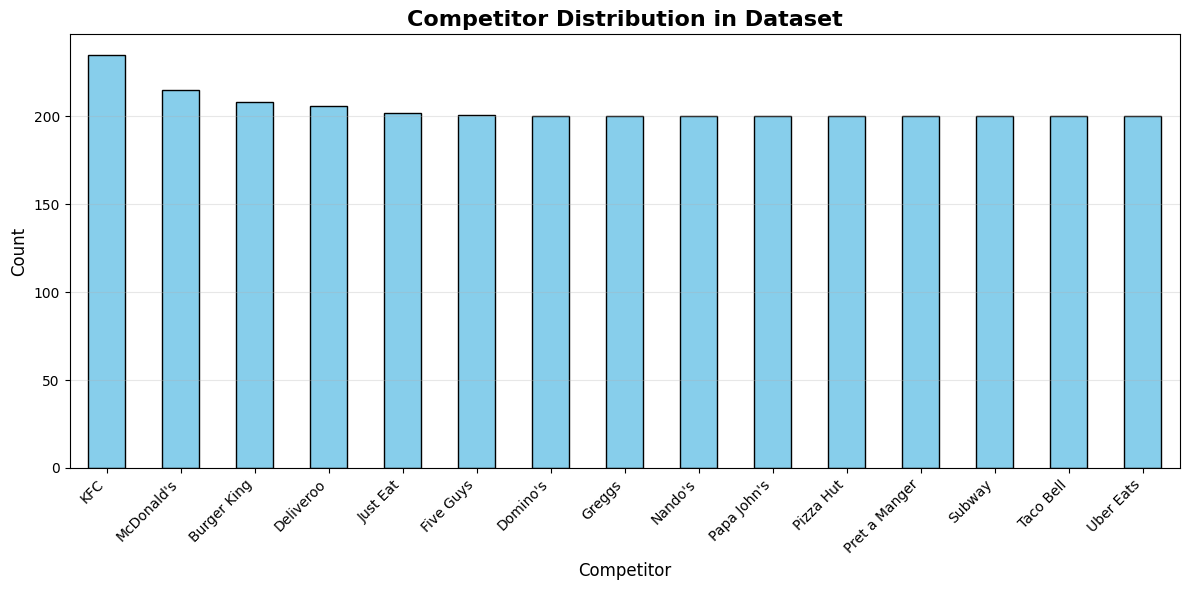


Class imbalance detected - will use class weights during training


In [14]:
# Analyze competitor distribution
print("Competitor Distribution in Large Dataset:")
competitor_counts = df_large['Competitor'].value_counts()
print(competitor_counts)

# Visualize
plt.figure(figsize=(12, 6))
competitor_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Competitor Distribution in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Competitor', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/competitor_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nClass imbalance detected - will use class weights during training")

## 4. Data Cleaning & Preprocessing

In [15]:
def clean_sentiment(value):
    """
    Extract numeric sentiment (0, 1, 2) from messy SENTIMENT column.
    Returns: 0 (negative), 1 (neutral), 2 (positive), or None if invalid
    """
    if pd.isna(value):
        return None

    # If already numeric
    if isinstance(value, (int, float)):
        if value in [0, 1, 2]:
            return int(value)
        return None

    # If string, try to extract
    value_str = str(value).strip().lower()

    # Direct matches
    if value_str in ['0', 'negative']:
        return 0
    elif value_str in ['1', 'neutral']:
        return 1
    elif value_str in ['2', 'positive']:
        return 2

    # Try to find digit at start
    match = re.match(r'^(\d)', value_str)
    if match:
        digit = int(match.group(1))
        if digit in [0, 1, 2]:
            return digit

    return None

# Test the function
test_values = [0, 1, 2, '0', '1', '2', 'negative', 'positive', 'some text', None, 735.14]
print("Testing clean_sentiment function:")
for val in test_values:
    print(f"  {val} -> {clean_sentiment(val)}")

Testing clean_sentiment function:
  0 -> 0
  1 -> 1
  2 -> 2
  0 -> 0
  1 -> 1
  2 -> 2
  negative -> 0
  positive -> 2
  some text -> None
  None -> None
  735.14 -> None


In [18]:
def prepare_dataset(df, name="dataset"):
    """
    Clean and prepare dataset:
    - Keep essential columns
    - Clean sentiment labels
    - Handle missing values
    - Clean tweet text
    """
    print(f"\nPreparing {name}...")
    print(f"  Initial rows: {len(df)}")

    # Identify available columns
    essential_cols = ['Competitor', 'Tweet', 'SENTIMENT']
    metadata_cols = ['Impact', 'Impressions', 'Reach (new)']
    multi_competitor_cols = ['KFC competitors', 'KFC competitors2', 'KFC competitors3']

    # Use Tweet column, or fallback to Title/Snippet/Full Text
    if 'Tweet' not in df.columns:
        if 'Full Text' in df.columns:
            df['Tweet'] = df['Full Text']
        elif 'Snippet' in df.columns:
            df['Tweet'] = df['Snippet']
        elif 'Title' in df.columns:
            df['Tweet'] = df['Title']

    # Select available columns
    cols_to_keep = [col for col in essential_cols if col in df.columns]
    cols_to_keep += [col for col in metadata_cols if col in df.columns]
    cols_to_keep += [col for col in multi_competitor_cols if col in df.columns]

    df_clean = df[cols_to_keep].copy()

    # Clean sentiment
    if 'SENTIMENT' in df_clean.columns:
        df_clean['SENTIMENT'] = df_clean['SENTIMENT'].apply(clean_sentiment)
        before_drop = len(df_clean)
        df_clean = df_clean.dropna(subset=['SENTIMENT'])
        print(f"  Dropped {before_drop - len(df_clean)} rows with invalid sentiment")
        df_clean['SENTIMENT'] = df_clean['SENTIMENT'].astype(int)

    # Drop rows with missing essential data
    before_drop = len(df_clean)
    df_clean = df_clean.dropna(subset=['Competitor', 'Tweet'])
    print(f"  Dropped {before_drop - len(df_clean)} rows with missing Competitor/Tweet")

    # Clean tweet text
    df_clean['Tweet'] = df_clean['Tweet'].astype(str).str.strip()
    df_clean = df_clean[df_clean['Tweet'].str.len() > 0]

    # Reset index
    df_clean = df_clean.reset_index(drop=True)

    print(f"  Final rows: {len(df_clean)}")
    print(f"  Columns: {df_clean.columns.tolist()}")

    return df_clean

# Apply to all datasets
# Rename 'Sentiment' to 'SENTIMENT' in df_large if it exists to match expected column name
if 'Sentiment' in df_large.columns:
    df_large.rename(columns={'Sentiment': 'SENTIMENT'}, inplace=True)
df_large_clean = prepare_dataset(df_large, "Large dataset")
df_train_clean = prepare_dataset(df_train_sample, "Training sample")
df_test_clean = prepare_dataset(df_test, "Test sample")


Preparing Large dataset...
  Initial rows: 3067
  Dropped 2265 rows with invalid sentiment
  Dropped 0 rows with missing Competitor/Tweet
  Final rows: 802
  Columns: ['Competitor', 'Tweet', 'SENTIMENT', 'Impact', 'Impressions', 'Reach (new)', 'KFC competitors', 'KFC competitors2', 'KFC competitors3']

Preparing Training sample...
  Initial rows: 259
  Dropped 0 rows with invalid sentiment
  Dropped 0 rows with missing Competitor/Tweet
  Final rows: 259
  Columns: ['Competitor', 'Tweet', 'SENTIMENT', 'Impact', 'Impressions', 'Reach (new)', 'KFC competitors', 'KFC competitors2', 'KFC competitors3']

Preparing Test sample...
  Initial rows: 34
  Dropped 0 rows with invalid sentiment
  Dropped 0 rows with missing Competitor/Tweet
  Final rows: 34
  Columns: ['Competitor', 'Tweet', 'SENTIMENT', 'Impact', 'Impressions', 'Reach (new)', 'KFC competitors', 'KFC competitors2', 'KFC competitors3']


Sentiment Distribution in Large Dataset:
  1 (neutral): 802 (100.0%)


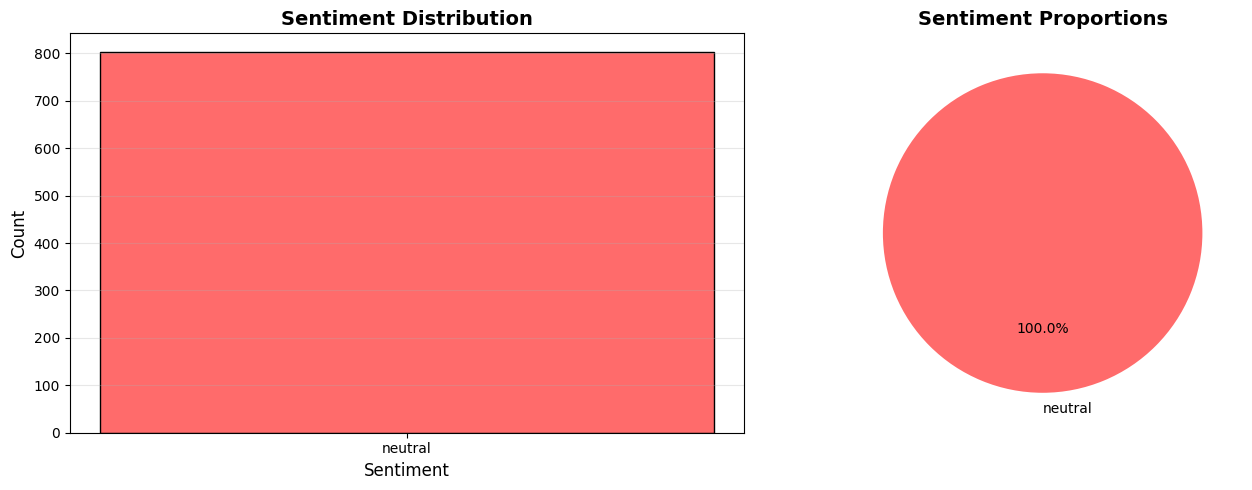

In [19]:
# Analyze sentiment distribution
print("Sentiment Distribution in Large Dataset:")
sentiment_counts = df_large_clean['SENTIMENT'].value_counts().sort_index()
for sent, count in sentiment_counts.items():
    print(f"  {sent} ({SENTIMENT_MAP[sent]}): {count} ({count/len(df_large_clean)*100:.1f}%)")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sentiment distribution
sentiment_labels = [SENTIMENT_MAP[s] for s in sentiment_counts.index]
axes[0].bar(sentiment_labels, sentiment_counts.values, color=['#ff6b6b', '#95a5a6', '#51cf66'], edgecolor='black')
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Sentiment pie chart
axes[1].pie(sentiment_counts.values, labels=sentiment_labels, autopct='%1.1f%%',
            colors=['#ff6b6b', '#95a5a6', '#51cf66'], startangle=90)
axes[1].set_title('Sentiment Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# Analyze multi-competitor tweets
def count_competitors_in_row(row):
    """Count how many competitors are mentioned in a row"""
    count = 1  # Primary competitor
    if 'KFC competitors' in row and pd.notna(row['KFC competitors']) and str(row['KFC competitors']).strip():
        count += 1
    if 'KFC competitors2' in row and pd.notna(row['KFC competitors2']) and str(row['KFC competitors2']).strip():
        count += 1
    if 'KFC competitors3' in row and pd.notna(row['KFC competitors3']) and str(row['KFC competitors3']).strip():
        count += 1
    return count

if 'KFC competitors' in df_large_clean.columns:
    df_large_clean['num_competitors'] = df_large_clean.apply(count_competitors_in_row, axis=1)
    multi_comp_counts = df_large_clean['num_competitors'].value_counts().sort_index()

    print("\nMulti-Competitor Tweet Analysis:")
    for num, count in multi_comp_counts.items():
        print(f"  {num} competitor(s): {count} tweets ({count/len(df_large_clean)*100:.1f}%)")

    # Show example of multi-competitor tweet
    multi_comp_example = df_large_clean[df_large_clean['num_competitors'] > 1].iloc[0]
    print("\nExample multi-competitor tweet:")
    print(f"  Primary: {multi_comp_example['Competitor']}")
    if pd.notna(multi_comp_example.get('KFC competitors')):
        print(f"  Also mentions: {multi_comp_example['KFC competitors']}")
    print(f"  Tweet: {multi_comp_example['Tweet'][:150]}...")
else:
    print("\nNo multi-competitor columns found in this dataset")


Multi-Competitor Tweet Analysis:
  1 competitor(s): 161 tweets (20.1%)
  2 competitor(s): 543 tweets (67.7%)
  3 competitor(s): 39 tweets (4.9%)
  4 competitor(s): 59 tweets (7.4%)

Example multi-competitor tweet:
  Primary: Burger King
  Also mentions: Burger King
  Tweet: 50 Cent hands out $30K in cash to Burger King employees in Queens https://t.co/QgsHU4ye4N...


In [27]:
def expand_multi_competitor_tweets(df):
    """
    Expand tweets with multiple competitors into separate rows.
    Each row will have (Tweet, Competitor, Sentiment, Metadata).
    Handles cases where 'KFC competitors' columns contain multiple comma-separated names.

    Note: For training, we assume same sentiment applies to all mentioned competitors.
    The model will learn to differentiate based on context.
    """
    expanded_rows = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Expanding multi-competitor tweets"):
        current_tweet_competitors = set()

        # Add the 'Competitor' value from the current row (primary competitor)
        # This is expected to be a single competitor name from the COMPETITORS list
        if row['Competitor'] in COMPETITORS:
            current_tweet_competitors.add(row['Competitor'])

        # Also, collect all explicit mentions from the KFC competitors columns
        # These columns can sometimes contain comma-separated values, or just one name
        for comp_col in ['KFC competitors', 'KFC competitors2', 'KFC competitors3']:
            if comp_col in row and pd.notna(row[comp_col]) and str(row[comp_col]).strip():
                # Split by comma to get individual competitor names
                competitor_names_str = str(row[comp_col]).strip()
                for c_name in [c.strip() for c in competitor_names_str.split(',')]:
                    if c_name in COMPETITORS: # Only add if it's a known single competitor
                        current_tweet_competitors.add(c_name)

        # Now create a new row for each unique competitor identified for this tweet
        if not current_tweet_competitors:
            # If no valid competitors were found (e.g., all were composite names not in COMPETITORS),
            # we should still add the original row with its primary competitor if it was valid
            # or handle it as a row without a relevant competitor if we couldn't parse.
            # For now, if current_tweet_competitors is empty, it means no valid individual competitor was found
            # according to our COMPETITORS list, so we might discard this row or keep it as is if needed.
            # Given the problem's context, it's better to ensure we only proceed with valid competitors.
            pass # Skip rows where no valid individual competitors could be extracted
        else:
            for competitor_to_add in current_tweet_competitors:
                new_row = row.to_dict().copy()
                new_row['Competitor'] = competitor_to_add
                expanded_rows.append(new_row)

    df_expanded = pd.DataFrame(expanded_rows)

    # Drop the multi-competitor columns and num_competitors if they exist
    cols_to_drop = [col for col in ['KFC competitors', 'KFC competitors2', 'KFC competitors3', 'num_competitors']
                    if col in df_expanded.columns]
    df_expanded = df_expanded.drop(columns=cols_to_drop, errors='ignore') # Use errors='ignore' for robustness

    # Ensure unique (Tweet, Competitor) pairs
    df_expanded.drop_duplicates(subset=['Tweet', 'Competitor'], inplace=True)

    return df_expanded.reset_index(drop=True)

# Expand large dataset
print(f"Before expansion: {len(df_large_clean)} rows")
df_expanded = expand_multi_competitor_tweets(df_large_clean)
print(f"After expansion: {len(df_expanded)} rows")
print(f"Added {len(df_expanded) - len(df_large_clean)} additional competitor-tweet pairs")

# Show updated competitor distribution
print("\nUpdated Competitor Distribution:")
print(df_expanded['Competitor'].value_counts())

Before expansion: 802 rows


Expanding multi-competitor tweets:   0%|          | 0/802 [00:00<?, ?it/s]

After expansion: 865 rows
Added 63 additional competitor-tweet pairs

Updated Competitor Distribution:
Competitor
McDonald's       101
KFC               90
Taco Bell         86
Uber Eats         74
Nando's           74
Papa John's       68
Burger King       57
Pizza Hut         53
Five Guys         53
Pret a Manger     45
Greggs            44
Just Eat          43
Deliveroo         40
Domino's          37
Name: count, dtype: int64


## 5. Rule-Based Baseline Model

In [22]:
def baseline_ner(tweet_text):
    """
    Simple rule-based competitor extraction using regex.
    Returns list of competitors found in tweet.
    """
    found_competitors = []
    tweet_lower = tweet_text.lower()

    # Check for each competitor (case-insensitive)
    for competitor in COMPETITORS:
        # Handle variations
        patterns = [competitor.lower()]

        # Add common variations
        if competitor == "McDonald's":
            patterns.extend(['mcdonald', 'mcdonalds', 'maccies', 'maccas', 'mickey d'])
        elif competitor == "KFC":
            patterns.extend(['kentucky fried chicken', 'kentucky'])
        elif competitor == "Nando's":
            patterns.extend(['nando', 'nandos'])
        elif competitor == "Papa John's":
            patterns.extend(['papa john', 'papa johns'])
        elif competitor == "Domino's":
            patterns.extend(['domino', 'dominos'])
        elif competitor == "Pret a Manger":
            patterns.extend(['pret'])

        # Check if any pattern matches
        for pattern in patterns:
            if re.search(r'\b' + re.escape(pattern) + r'\b', tweet_lower):
                found_competitors.append(competitor)
                break

    return found_competitors

# Test baseline NER
test_tweets = [
    "I love KFC's chicken!",
    "McDonald's fries are better than Burger King",
    "Just ordered from Deliveroo",
    "This is a random tweet with no competitors"
]

print("Testing Baseline NER:")
for tweet in test_tweets:
    competitors = baseline_ner(tweet)
    print(f"  Tweet: {tweet}")
    print(f"  Found: {competitors}\n")

Testing Baseline NER:
  Tweet: I love KFC's chicken!
  Found: ['KFC']

  Tweet: McDonald's fries are better than Burger King
  Found: ['Burger King', "McDonald's"]

  Tweet: Just ordered from Deliveroo
  Found: ['Deliveroo']

  Tweet: This is a random tweet with no competitors
  Found: []



In [23]:
def baseline_sentiment(tweet_text):
    """
    Simple lexicon-based sentiment analysis.
    Returns: 0 (negative), 1 (neutral), 2 (positive)
    """
    # Simple positive/negative word lists
    positive_words = [
        'good', 'great', 'excellent', 'amazing', 'awesome', 'love', 'best', 'perfect',
        'delicious', 'tasty', 'yummy', 'fantastic', 'wonderful', 'brilliant', 'nice',
        'happy', 'satisfied', 'enjoyed', 'recommend', 'favorite', 'favourite'
    ]

    negative_words = [
        'bad', 'terrible', 'awful', 'horrible', 'worst', 'hate', 'poor', 'disgusting',
        'nasty', 'gross', 'disappointing', 'disappointed', 'never', 'rubbish', 'trash',
        'cold', 'overpriced', 'expensive', 'slow', 'rude', 'complaint'
    ]

    tweet_lower = tweet_text.lower()

    # Count positive and negative words
    pos_count = sum(1 for word in positive_words if re.search(r'\b' + word + r'\b', tweet_lower))
    neg_count = sum(1 for word in negative_words if re.search(r'\b' + word + r'\b', tweet_lower))

    # Simple logic
    if pos_count > neg_count:
        return 2  # positive
    elif neg_count > pos_count:
        return 0  # negative
    else:
        return 1  # neutral

# Test baseline sentiment
test_tweets = [
    "I love this place! The food is amazing!",
    "This is terrible. Worst experience ever.",
    "I went to the store today.",
    "Great chicken but terrible service"
]

print("Testing Baseline Sentiment:")
for tweet in test_tweets:
    sentiment = baseline_sentiment(tweet)
    print(f"  Tweet: {tweet}")
    print(f"  Sentiment: {sentiment} ({SENTIMENT_MAP[sentiment]})\n")

Testing Baseline Sentiment:
  Tweet: I love this place! The food is amazing!
  Sentiment: 2 (positive)

  Tweet: This is terrible. Worst experience ever.
  Sentiment: 0 (negative)

  Tweet: I went to the store today.
  Sentiment: 1 (neutral)

  Tweet: Great chicken but terrible service
  Sentiment: 1 (neutral)



Evaluating Baseline Model on Test Set...

Baseline NER Accuracy: 0.971
  Correctly identified competitor in 33/34 tweets

Baseline Sentiment Accuracy: 0.441
Baseline Sentiment F1 (macro): 0.316

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         6
     neutral       0.36      0.91      0.51        11
    positive       0.83      0.29      0.43        17

    accuracy                           0.44        34
   macro avg       0.40      0.40      0.32        34
weighted avg       0.53      0.44      0.38        34



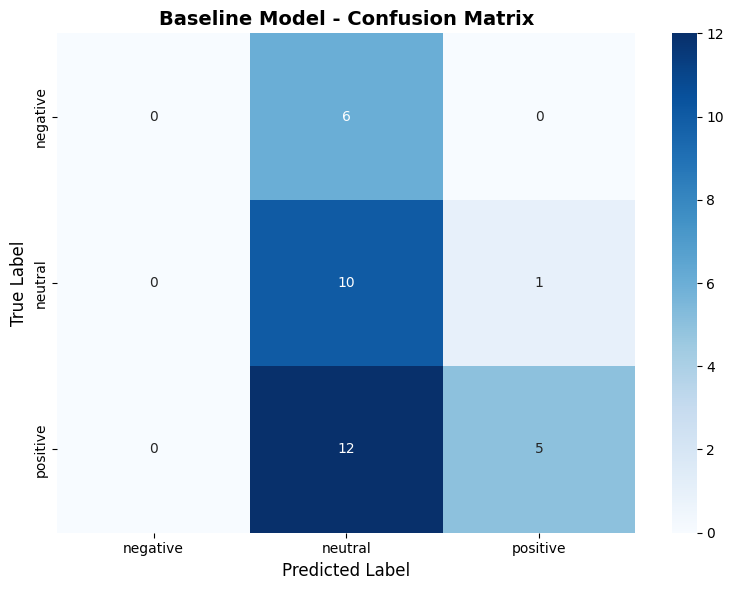


Baseline model establishes our performance floor.
Deep learning models should significantly outperform these metrics.


In [24]:
# Evaluate baseline on test set
def evaluate_baseline(df_test):
    """
    Evaluate baseline model on test set.
    """
    print("Evaluating Baseline Model on Test Set...\n")

    # NER evaluation
    ner_correct = 0
    ner_total = len(df_test)

    # Sentiment evaluation
    y_true = []
    y_pred = []

    for idx, row in df_test.iterrows():
        tweet = row['Tweet']
        true_competitor = row['Competitor']
        true_sentiment = row['SENTIMENT']

        # NER: Check if baseline finds the correct competitor
        found_competitors = baseline_ner(tweet)
        if true_competitor in found_competitors:
            ner_correct += 1

        # Sentiment
        pred_sentiment = baseline_sentiment(tweet)
        y_true.append(true_sentiment)
        y_pred.append(pred_sentiment)

    # NER metrics
    ner_accuracy = ner_correct / ner_total
    print(f"Baseline NER Accuracy: {ner_accuracy:.3f}")
    print(f"  Correctly identified competitor in {ner_correct}/{ner_total} tweets\n")

    # Sentiment metrics
    sentiment_accuracy = accuracy_score(y_true, y_pred)
    sentiment_f1_macro = f1_score(y_true, y_pred, average='macro')

    print(f"Baseline Sentiment Accuracy: {sentiment_accuracy:.3f}")
    print(f"Baseline Sentiment F1 (macro): {sentiment_f1_macro:.3f}\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred,
                                target_names=['negative', 'neutral', 'positive'],
                                zero_division=0))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title('Baseline Model - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'ner_accuracy': ner_accuracy,
        'sentiment_accuracy': sentiment_accuracy,
        'sentiment_f1_macro': sentiment_f1_macro
    }

# Run baseline evaluation
baseline_results = evaluate_baseline(df_test_clean)
print("\n" + "="*50)
print("Baseline model establishes our performance floor.")
print("Deep learning models should significantly outperform these metrics.")
print("="*50)

## 6. Prepare Training Data

In [26]:
# Create stratified train/validation split
# Stratify by both competitor and sentiment to ensure balanced representation

# Create stratification key
df_expanded['stratify_key'] = df_expanded['Competitor'] + '_' + df_expanded['SENTIMENT'].astype(str)

# Check if we have enough samples for each combination
stratify_counts = df_expanded['stratify_key'].value_counts()
print(f"Number of unique Competitor-Sentiment combinations: {len(stratify_counts)}")
print(f"Minimum samples in a combination: {stratify_counts.min()}")

# For combinations with only 1 sample, we can't stratify perfectly
# Use a more robust approach
rare_combinations = stratify_counts[stratify_counts < 2].index
if len(rare_combinations) > 0:
    print(f"\nWarning: {len(rare_combinations)} combinations have <2 samples")
    print("Using competitor-only stratification for robustness")
    stratify_column = df_expanded['Competitor']
else:
    stratify_column = df_expanded['stratify_key']

# Split data (80/20)
train_df, val_df = train_test_split(
    df_expanded,
    test_size=0.2,
    random_state=SEED,
    stratify=stratify_column
)

print(f"\nDataset Split:")
print(f"  Training: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Test: {len(df_test_clean)} samples")

# Verify distribution is preserved
print("\nCompetitor distribution in splits:")
print("Training:")
print(train_df['Competitor'].value_counts(normalize=True).head())
print("\nValidation:")
print(val_df['Competitor'].value_counts(normalize=True).head())

Number of unique Competitor-Sentiment combinations: 28
Minimum samples in a combination: 1

Using competitor-only stratification for robustness


ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## 7. NER Model - Competitor Extraction

We'll use a multi-label classification approach:
- Input: Tweet text
- Output: Binary vector indicating which competitors are mentioned (14 dimensions)

In [ ]:
class CompetitorNERDataset(Dataset):
    """
    Dataset for multi-label competitor identification.
    Each sample is labeled with which competitors are mentioned.
    """

    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Group by tweet to identify all competitors in each tweet
        self.tweet_groups = self.data.groupby('Tweet')['Competitor'].apply(list).to_dict()
        self.unique_tweets = list(self.tweet_groups.keys())

    def __len__(self):
        return len(self.unique_tweets)

    def __getitem__(self, idx):
        tweet = self.unique_tweets[idx]
        competitors_in_tweet = self.tweet_groups[tweet]

        # Tokenize tweet
        encoding = self.tokenizer(
            tweet,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Create multi-label target (binary vector for each competitor)
        labels = torch.zeros(len(COMPETITORS), dtype=torch.float)
        for competitor in competitors_in_tweet:
            if competitor in COMPETITORS:
                labels[COMPETITORS.index(competitor)] = 1.0

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels
        }

print("CompetitorNERDataset class created successfully!")

In [ ]:
class MultiLabelCompetitorModel(nn.Module):
    """
    Multi-label classifier for competitor identification.
    Uses BERT with sigmoid activation for independent binary predictions.
    """

    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            problem_type="multi_label_classification"
        )

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        return outputs

print("MultiLabelCompetitorModel class created successfully!")

In [ ]:
# Load tokenizer for NER model
print(f"Loading tokenizer: {NER_MODEL_NAME}")
ner_tokenizer = AutoTokenizer.from_pretrained(NER_MODEL_NAME)

# Create datasets
print("\nCreating NER datasets...")
ner_train_dataset = CompetitorNERDataset(train_df, ner_tokenizer, MAX_SEQ_LENGTH)
ner_val_dataset = CompetitorNERDataset(val_df, ner_tokenizer, MAX_SEQ_LENGTH)
ner_test_dataset = CompetitorNERDataset(df_test_clean, ner_tokenizer, MAX_SEQ_LENGTH)

print(f"  Train: {len(ner_train_dataset)} unique tweets")
print(f"  Validation: {len(ner_val_dataset)} unique tweets")
print(f"  Test: {len(ner_test_dataset)} unique tweets")

# Create dataloaders
ner_train_loader = DataLoader(
    ner_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

ner_val_loader = DataLoader(
    ner_val_dataset,
    batch_size=BATCH_SIZE * 2,  # Can use larger batch for inference
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

ner_test_loader = DataLoader(
    ner_test_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoaders created with batch size {BATCH_SIZE}")

In [ ]:
def train_ner_model(model, train_loader, val_loader, epochs, learning_rate):
    """
    Train the NER (multi-label competitor identification) model.
    """
    model = model.to(device)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * epochs // GRAD_ACCUM_STEPS
    warmup_steps = int(total_steps * WARMUP_RATIO)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Mixed precision training
    scaler = GradScaler()

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': []
    }

    best_val_f1 = 0

    print(f"\nStarting NER model training...")
    print(f"  Total epochs: {epochs}")
    print(f"  Total steps: {total_steps}")
    print(f"  Warmup steps: {warmup_steps}")
    print(f"  Gradient accumulation: {GRAD_ACCUM_STEPS}\n")

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 50)

        # Training phase
        model.train()
        train_loss = 0
        optimizer.zero_grad()

        train_pbar = tqdm(train_loader, desc="Training")
        for step, batch in enumerate(train_pbar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Mixed precision forward pass
            with autocast():
                outputs = model(input_ids, attention_mask, labels)
                loss = outputs.loss / GRAD_ACCUM_STEPS

            # Backward pass
            scaler.scale(loss).backward()

            # Update weights every GRAD_ACCUM_STEPS
            if (step + 1) % GRAD_ACCUM_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

            train_loss += loss.item() * GRAD_ACCUM_STEPS
            train_pbar.set_postfix({'loss': f'{loss.item() * GRAD_ACCUM_STEPS:.4f}'})

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc="Validation")
            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                with autocast():
                    outputs = model(input_ids, attention_mask, labels)

                val_loss += outputs.loss.item()

                # Get predictions (threshold at 0.5)
                logits = outputs.logits
                preds = (torch.sigmoid(logits) > 0.5).float()

                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        # Calculate F1 score
        all_preds = torch.cat(all_preds).numpy()
        all_labels = torch.cat(all_labels).numpy()
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        history['val_f1'].append(val_f1)

        print(f"\nEpoch {epoch + 1} Results:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Val F1 (macro): {val_f1:.4f}")

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            print(f"  New best F1! Saving model...")
            torch.save(model.state_dict(), f'{MODEL_SAVE_DIR}/ner_best_model.pt')

        print()

        # Clear cache
        torch.cuda.empty_cache()
        gc.collect()

    print(f"\nTraining complete!")
    print(f"Best validation F1: {best_val_f1:.4f}")

    return model, history

print("Train function defined successfully!")

In [ ]:
# Initialize and train NER model
print(f"Initializing NER model: {NER_MODEL_NAME}")
ner_model = MultiLabelCompetitorModel(NER_MODEL_NAME, num_labels=len(COMPETITORS))

# Train model
ner_model, ner_history = train_ner_model(
    ner_model,
    ner_train_loader,
    ner_val_loader,
    epochs=NER_EPOCHS,
    learning_rate=NER_LEARNING_RATE
)

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(ner_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(ner_history['val_loss'], label='Val Loss', marker='s')
axes[0].set_title('NER Model - Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# F1 Score
axes[1].plot(ner_history['val_f1'], label='Val F1 (macro)', marker='o', color='green')
axes[1].set_title('NER Model - Validation F1 Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/ner_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluate NER model on test set
def evaluate_ner_model(model, test_loader):
    """
    Evaluate NER model and return detailed metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating NER"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with autocast():
                outputs = model(input_ids, attention_mask)

            logits = outputs.logits
            preds = (torch.sigmoid(logits) > 0.5).float()

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Overall metrics
    overall_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    overall_precision = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)[0]
    overall_recall = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)[1]

    print("\n" + "="*50)
    print("NER Model Test Results")
    print("="*50)
    print(f"Overall Precision: {overall_precision:.4f}")
    print(f"Overall Recall: {overall_recall:.4f}")
    print(f"Overall F1 (macro): {overall_f1:.4f}")

    # Per-competitor metrics
    print("\nPer-Competitor Performance:")
    print("-" * 50)
    per_competitor_f1 = []
    for i, competitor in enumerate(COMPETITORS):
        if all_labels[:, i].sum() > 0:  # Only if competitor appears in test set
            f1 = f1_score(all_labels[:, i], all_preds[:, i], zero_division=0)
            per_competitor_f1.append((competitor, f1))
            print(f"  {competitor:20s}: F1 = {f1:.4f}")

    return {
        'overall_f1': overall_f1,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'per_competitor_f1': per_competitor_f1
    }

# Load best model and evaluate
ner_model.load_state_dict(torch.load(f'{MODEL_SAVE_DIR}/ner_best_model.pt'))
ner_test_results = evaluate_ner_model(ner_model, ner_test_loader)

## 8. Sentiment Model - Competitor-Specific Sentiment Classification

We'll fine-tune a Twitter-specific RoBERTa model for sentiment classification.
Input format: `"[Tweet text] This tweet is about [Competitor name]."`

In [ ]:
class SentimentDataset(Dataset):
    """
    Dataset for competitor-specific sentiment classification.
    """

    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        tweet = row['Tweet']
        competitor = row['Competitor']
        sentiment = row['SENTIMENT']

        # Create contextualized input
        text = f"{tweet} This tweet is about {competitor}."

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(sentiment, dtype=torch.long)
        }

print("SentimentDataset class created successfully!")

In [ ]:
# Load tokenizer for sentiment model
print(f"Loading tokenizer: {SENTIMENT_MODEL_NAME}")
sentiment_tokenizer = AutoTokenizer.from_pretrained(SENTIMENT_MODEL_NAME)

# Create datasets (using expanded data with competitor-tweet pairs)
print("\nCreating Sentiment datasets...")
sentiment_train_dataset = SentimentDataset(train_df, sentiment_tokenizer, MAX_SEQ_LENGTH)
sentiment_val_dataset = SentimentDataset(val_df, sentiment_tokenizer, MAX_SEQ_LENGTH)
sentiment_test_dataset = SentimentDataset(df_test_clean, sentiment_tokenizer, MAX_SEQ_LENGTH)

print(f"  Train: {len(sentiment_train_dataset)} samples")
print(f"  Validation: {len(sentiment_val_dataset)} samples")
print(f"  Test: {len(sentiment_test_dataset)} samples")

# Calculate class weights for imbalanced data
train_sentiments = train_df['SENTIMENT'].values
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_sentiments),
    y=train_sentiments
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"\nClass weights for imbalanced sentiment:")
for i, weight in enumerate(class_weights):
    print(f"  {SENTIMENT_MAP[i]:8s}: {weight:.3f}")

# Create dataloaders
sentiment_train_loader = DataLoader(
    sentiment_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

sentiment_val_loader = DataLoader(
    sentiment_val_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

sentiment_test_loader = DataLoader(
    sentiment_test_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoaders created with batch size {BATCH_SIZE}")

In [ ]:
def train_sentiment_model(model, train_loader, val_loader, epochs, learning_rate, class_weights):
    """
    Train the sentiment classification model with class weights.
    """
    model = model.to(device)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=WEIGHT_DECAY)

    total_steps = len(train_loader) * epochs // GRAD_ACCUM_STEPS
    warmup_steps = int(total_steps * WARMUP_RATIO)

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    # Loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Mixed precision training
    scaler = GradScaler()

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': []
    }

    best_val_f1 = 0

    print(f"\nStarting Sentiment model training...")
    print(f"  Total epochs: {epochs}")
    print(f"  Total steps: {total_steps}")
    print(f"  Warmup steps: {warmup_steps}")
    print(f"  Gradient accumulation: {GRAD_ACCUM_STEPS}\n")

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 50)

        # Training phase
        model.train()
        train_loss = 0
        optimizer.zero_grad()

        train_pbar = tqdm(train_loader, desc="Training")
        for step, batch in enumerate(train_pbar):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Mixed precision forward pass
            with autocast():
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs.logits, labels) / GRAD_ACCUM_STEPS

            # Backward pass
            scaler.scale(loss).backward()

            # Update weights every GRAD_ACCUM_STEPS
            if (step + 1) % GRAD_ACCUM_STEPS == 0:
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

            train_loss += loss.item() * GRAD_ACCUM_STEPS
            train_pbar.set_postfix({'loss': f'{loss.item() * GRAD_ACCUM_STEPS:.4f}'})

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc="Validation")
            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                with autocast():
                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs.logits, labels)

                val_loss += loss.item()

                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        # Calculate metrics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        history['val_accuracy'].append(val_accuracy)
        history['val_f1'].append(val_f1)

        print(f"\nEpoch {epoch + 1} Results:")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Val Accuracy: {val_accuracy:.4f}")
        print(f"  Val F1 (macro): {val_f1:.4f}")

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            print(f"  New best F1! Saving model...")
            torch.save(model.state_dict(), f'{MODEL_SAVE_DIR}/sentiment_best_model.pt')

        print()

        # Clear cache
        torch.cuda.empty_cache()
        gc.collect()

    print(f"\nTraining complete!")
    print(f"Best validation F1: {best_val_f1:.4f}")

    return model, history

print("Sentiment train function defined successfully!")

In [ ]:
# Initialize and train sentiment model
print(f"Initializing Sentiment model: {SENTIMENT_MODEL_NAME}")
sentiment_model = AutoModelForSequenceClassification.from_pretrained(
    SENTIMENT_MODEL_NAME,
    num_labels=3,  # negative, neutral, positive
    ignore_mismatched_sizes=True  # In case pre-trained model has different num_labels
)

# Train model
sentiment_model, sentiment_history = train_sentiment_model(
    sentiment_model,
    sentiment_train_loader,
    sentiment_val_loader,
    epochs=SENTIMENT_EPOCHS,
    learning_rate=SENTIMENT_LEARNING_RATE,
    class_weights=class_weights
)

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(sentiment_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(sentiment_history['val_loss'], label='Val Loss', marker='s')
axes[0].set_title('Sentiment Model - Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(sentiment_history['val_accuracy'], label='Val Accuracy', marker='o', color='blue')
axes[1].set_title('Sentiment Model - Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

# F1 Score
axes[2].plot(sentiment_history['val_f1'], label='Val F1 (macro)', marker='o', color='green')
axes[2].set_title('Sentiment Model - Validation F1 Score', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/sentiment_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Evaluate sentiment model on test set
def evaluate_sentiment_model(model, test_loader):
    """
    Evaluate sentiment model and return detailed metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating Sentiment"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            with autocast():
                outputs = model(input_ids, attention_mask)

            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    print("\n" + "="*50)
    print("Sentiment Model Test Results")
    print("="*50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"F1 Score (weighted): {f1_weighted:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(
        all_labels, all_preds,
        target_names=['negative', 'neutral', 'positive'],
        zero_division=0
    ))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title('Sentiment Model - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'{RESULTS_DIR}/sentiment_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'predictions': all_preds,
        'labels': all_labels
    }

# Load best model and evaluate
sentiment_model.load_state_dict(torch.load(f'{MODEL_SAVE_DIR}/sentiment_best_model.pt'))
sentiment_test_results = evaluate_sentiment_model(sentiment_model, sentiment_test_loader)

## 9. Integrated Pipeline - End-to-End Inference

Combine NER and Sentiment models to:
1. Extract all competitors from tweet
2. Predict sentiment for each competitor
3. Generate output with one row per competitor

In [ ]:
def predict_competitors_and_sentiment(tweet_text, ner_model, sentiment_model,
                                      ner_tokenizer, sentiment_tokenizer,
                                      threshold=0.5):
    """
    End-to-end prediction:
    1. Extract competitors using NER model
    2. For each competitor, predict sentiment

    Returns: List of (competitor, sentiment) tuples
    """
    ner_model.eval()
    sentiment_model.eval()

    # Step 1: Extract competitors
    ner_encoding = ner_tokenizer(
        tweet_text,
        add_special_tokens=True,
        max_length=MAX_SEQ_LENGTH,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    with torch.no_grad():
        with autocast():
            ner_outputs = ner_model(
                ner_encoding['input_ids'].to(device),
                ner_encoding['attention_mask'].to(device)
            )

    # Get competitor predictions (apply sigmoid and threshold)
    ner_probs = torch.sigmoid(ner_outputs.logits).cpu().numpy()[0]
    detected_competitors = [COMPETITORS[i] for i, prob in enumerate(ner_probs) if prob > threshold]

    if len(detected_competitors) == 0:
        # Fallback: use baseline NER if model finds nothing
        detected_competitors = baseline_ner(tweet_text)

    # Step 2: For each competitor, predict sentiment
    results = []

    for competitor in detected_competitors:
        # Create contextualized input
        text = f"{tweet_text} This tweet is about {competitor}."

        sentiment_encoding = sentiment_tokenizer(
            text,
            add_special_tokens=True,
            max_length=MAX_SEQ_LENGTH,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        with torch.no_grad():
            with autocast():
                sentiment_outputs = sentiment_model(
                    sentiment_encoding['input_ids'].to(device),
                    sentiment_encoding['attention_mask'].to(device)
                )

        predicted_sentiment = torch.argmax(sentiment_outputs.logits, dim=1).item()
        results.append((competitor, predicted_sentiment))

    return results

# Test the pipeline
test_tweets = [
    "I love KFC's chicken!",
    "McDonald's fries are amazing but their burgers are terrible",
    "Just ordered from Deliveroo and the food was cold",
]

print("Testing Integrated Pipeline:\n")
for tweet in test_tweets:
    results = predict_competitors_and_sentiment(
        tweet, ner_model, sentiment_model,
        ner_tokenizer, sentiment_tokenizer
    )
    print(f"Tweet: {tweet}")
    for competitor, sentiment in results:
        print(f"  {competitor}: {SENTIMENT_MAP[sentiment]}")
    print()

In [ ]:
def process_dataset_with_pipeline(df, ner_model, sentiment_model,
                                  ner_tokenizer, sentiment_tokenizer):
    """
    Process entire dataset through the pipeline.
    Returns DataFrame with one row per detected competitor.
    """
    results = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Processing tweets"):
        tweet = row['Tweet']

        # Get predictions
        predictions = predict_competitors_and_sentiment(
            tweet, ner_model, sentiment_model,
            ner_tokenizer, sentiment_tokenizer
        )

        # Create row for each detected competitor
        for competitor, sentiment in predictions:
            result_row = {
                'Competitor': competitor,
                'Tweet': tweet,
                'Predicted_Sentiment': sentiment,
                'Sentiment_Label': SENTIMENT_MAP[sentiment]
            }

            # Add metadata if available
            for col in ['Impact', 'Impressions', 'Reach (new)']:
                if col in row:
                    result_row[col] = row[col]

            results.append(result_row)

    return pd.DataFrame(results)

print("Pipeline processing function created!")

## 10. Generate Predictions for Test Data

In [ ]:
# Process test data for prediction
print("Generating predictions for KFC_test_sample_for_prediction.csv...\n")

# Prepare test prediction data (might not have SENTIMENT column)
if 'SENTIMENT' not in df_test_pred.columns:
    df_test_pred['SENTIMENT'] = 1  # Dummy value for processing

df_test_pred_clean = prepare_dataset(df_test_pred, "Test prediction data")

# Generate predictions
predictions_df = process_dataset_with_pipeline(
    df_test_pred_clean,
    ner_model,
    sentiment_model,
    ner_tokenizer,
    sentiment_tokenizer
)

print(f"\nGenerated {len(predictions_df)} predictions from {len(df_test_pred_clean)} tweets")
print(f"Average competitors per tweet: {len(predictions_df) / len(df_test_pred_clean):.2f}")

# Display sample predictions
print("\nSample Predictions:")
print(predictions_df.head(10))

# Save predictions
predictions_output_path = f'{RESULTS_DIR}/KFC_test_predictions.csv'
predictions_df.to_csv(predictions_output_path, index=False)
print(f"\nPredictions saved to: {predictions_output_path}")

## 11. Final Evaluation & Comparison

In [ ]:
# Compare baseline vs. fine-tuned models
print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

print("\n1. NER (Competitor Extraction) Performance:")
print("-" * 70)
print(f"Baseline NER Accuracy:        {baseline_results['ner_accuracy']:.4f}")
print(f"Fine-tuned NER F1 (macro):    {ner_test_results['overall_f1']:.4f}")
print(f"Improvement:                  {(ner_test_results['overall_f1'] - baseline_results['ner_accuracy']):.4f}")

print("\n2. Sentiment Classification Performance:")
print("-" * 70)
print(f"Baseline Sentiment Accuracy:  {baseline_results['sentiment_accuracy']:.4f}")
print(f"Fine-tuned Sentiment Accuracy: {sentiment_test_results['accuracy']:.4f}")
print(f"Improvement:                  {(sentiment_test_results['accuracy'] - baseline_results['sentiment_accuracy']):.4f}")

print(f"\nBaseline Sentiment F1:        {baseline_results['sentiment_f1_macro']:.4f}")
print(f"Fine-tuned Sentiment F1:      {sentiment_test_results['f1_macro']:.4f}")
print(f"Improvement:                  {(sentiment_test_results['f1_macro'] - baseline_results['sentiment_f1_macro']):.4f}")

print("\n" + "="*70)
print("Models successfully fine-tuned and evaluated!")
print("="*70)

In [ ]:
# Visualize performance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# NER comparison
ner_methods = ['Baseline', 'Fine-tuned']
ner_scores = [baseline_results['ner_accuracy'], ner_test_results['overall_f1']]
axes[0].bar(ner_methods, ner_scores, color=['#ff7f0e', '#2ca02c'], edgecolor='black')
axes[0].set_title('NER Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, score in enumerate(ner_scores):
    axes[0].text(i, score + 0.02, f'{score:.3f}', ha='center', fontweight='bold')

# Sentiment comparison
sentiment_methods = ['Baseline', 'Fine-tuned']
sentiment_scores = [baseline_results['sentiment_f1_macro'], sentiment_test_results['f1_macro']]
axes[1].bar(sentiment_methods, sentiment_scores, color=['#ff7f0e', '#2ca02c'], edgecolor='black')
axes[1].set_title('Sentiment F1 Performance Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('F1 Score (macro)', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, score in enumerate(sentiment_scores):
    axes[1].text(i, score + 0.02, f'{score:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Save Models to Google Drive

In [ ]:
# Save tokenizers and final configuration
print("Saving models and tokenizers to Google Drive...\n")

# Save tokenizers
ner_tokenizer.save_pretrained(f'{MODEL_SAVE_DIR}/ner_tokenizer')
sentiment_tokenizer.save_pretrained(f'{MODEL_SAVE_DIR}/sentiment_tokenizer')

# Save full models (optional - files will be large)
ner_model.bert.save_pretrained(f'{MODEL_SAVE_DIR}/ner_full_model')
sentiment_model.save_pretrained(f'{MODEL_SAVE_DIR}/sentiment_full_model')

# Save configuration
config = {
    'competitors': COMPETITORS,
    'sentiment_map': SENTIMENT_MAP,
    'ner_model_name': NER_MODEL_NAME,
    'sentiment_model_name': SENTIMENT_MODEL_NAME,
    'max_seq_length': MAX_SEQ_LENGTH,
    'ner_epochs': NER_EPOCHS,
    'sentiment_epochs': SENTIMENT_EPOCHS,
    'batch_size': BATCH_SIZE,
    'baseline_results': baseline_results,
    'ner_test_results': ner_test_results,
    'sentiment_test_results': {
        'accuracy': sentiment_test_results['accuracy'],
        'f1_macro': sentiment_test_results['f1_macro'],
        'f1_weighted': sentiment_test_results['f1_weighted']
    }
}

import json
with open(f'{MODEL_SAVE_DIR}/config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("✓ Models and tokenizers saved successfully!")
print(f"\nSaved to: {MODEL_SAVE_DIR}/")
print("  - ner_best_model.pt")
print("  - sentiment_best_model.pt")
print("  - ner_tokenizer/")
print("  - sentiment_tokenizer/")
print("  - ner_full_model/")
print("  - sentiment_full_model/")
print("  - config.json")

## 13. Summary & Next Steps

In [ ]:
print("\n" + "="*70)
print("TRAINING COMPLETE - SUMMARY")
print("="*70)

print("\n📊 Dataset Statistics:")
print(f"  Training samples: {len(train_df)}")
print(f"  Validation samples: {len(val_df)}")
print(f"  Test samples: {len(df_test_clean)}")
print(f"  Total competitors: {len(COMPETITORS)}")

print("\n🎯 Model Performance:")
print(f"  NER F1 Score: {ner_test_results['overall_f1']:.4f}")
print(f"  Sentiment Accuracy: {sentiment_test_results['accuracy']:.4f}")
print(f"  Sentiment F1 (macro): {sentiment_test_results['f1_macro']:.4f}")

print("\n📁 Output Files:")
print(f"  Predictions: {RESULTS_DIR}/KFC_test_predictions.csv")
print(f"  Models: {MODEL_SAVE_DIR}/")
print(f"  Visualizations: {RESULTS_DIR}/")

print("\n✨ Key Features:")
print("  ✓ Multi-competitor extraction")
print("  ✓ Competitor-specific sentiment analysis")
print("  ✓ Handles tweets mentioning multiple competitors")
print("  ✓ Class-weighted training for imbalanced data")
print("  ✓ Mixed precision training for efficiency")

print("\n🚀 Next Steps:")
print("  1. Review predictions in KFC_test_predictions.csv")
print("  2. Analyze error cases to identify improvement areas")
print("  3. Consider data augmentation for underrepresented competitors")
print("  4. Fine-tune threshold for NER (currently 0.5)")
print("  5. Deploy models for real-time inference")

print("\n" + "="*70)
print("Thank you for using this pipeline!")
print("="*70)